# **ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ - ΕΡΓΑΣΙΑ 1**

**ΡΟΥΣΟΣ ΣΤΑΜΑΤΗΣ**


# **ΕΙΣΑΓΩΓΗ**

Σε αυτη την εργασια θα προσπαθησω να χτισω ενα CNN με συνελικτικα και πληρως συνδεδεμενα επιπεδα, το οποιο θα κατηγοριοποιει εικονες σε 10 κλασεις. Θα δουλεψω πανω στο Cifar-10 Dataset. Επειδη το Notebook βγηκε πολυ μεγαλο, κατω-κατω στις παρατηρησεις περιεχω μια συνοψη της πορειας που ακολουθησα στην εργασια. Η εργασια εγινε εξ ολοκληρου στο Google Colaboratory που επιτρεπει τη χρηση GPU, χρησιμοποιωντας το **Keras API του Tensorflow framework**.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import time

# **Pre-Processing the Data**

In [ ]:
# 1. Load data: CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Original shapes:")
print("X_train shape:", x_train.shape, "\ny_train shape:", y_train.shape, "\nX_test shape:", x_test.shape, "\ny_test shape:", y_test.shape)
class_names = ["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]
print("\nClasses:")
for i, name in enumerate(class_names):
    print(i, "->", name)

# 2. Normalization: [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# 3. 10% validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.1,random_state=42,stratify=y_train)   # κρατάει τις αναλογίες κλάσεων
print("\nPost validation shapes:")
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

# κάνε το (5000, 1) → (5000,)
y_val_flat = y_val.squeeze()      # ή y_val.reshape(-1)

counts = np.bincount(y_val_flat)
print("\nValidation set:")
for i, count in enumerate(counts):
    print(f"{class_names[i]}: {count}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Original shapes:
X_train shape: (50000, 32, 32, 3) 
y_train shape: (50000, 1) 
X_test shape: (10000, 32, 32, 3) 
y_test shape: (10000, 1)

Classes:
0 -> airplane
1 -> automobile
2 -> bird
3 -> cat
4 -> deer
5 -> dog
6 -> frog
7 -> horse
8 -> ship
9 -> truck

Post validation shapes:
X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
x_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 1)

Validation set:
airplane: 500
automobile: 500
bird: 500
cat: 500
deer: 500
dog: 500
frog: 500
horse: 500
ship: 500
truck: 500


# **Data Visualization**
Εδω θα κανω μια οπτικοποιηση μερικων δειγματων εκπαιδευσης προκειμενου να δω τι παιζει με τις εικονες στο Cifar 10 Dataset.

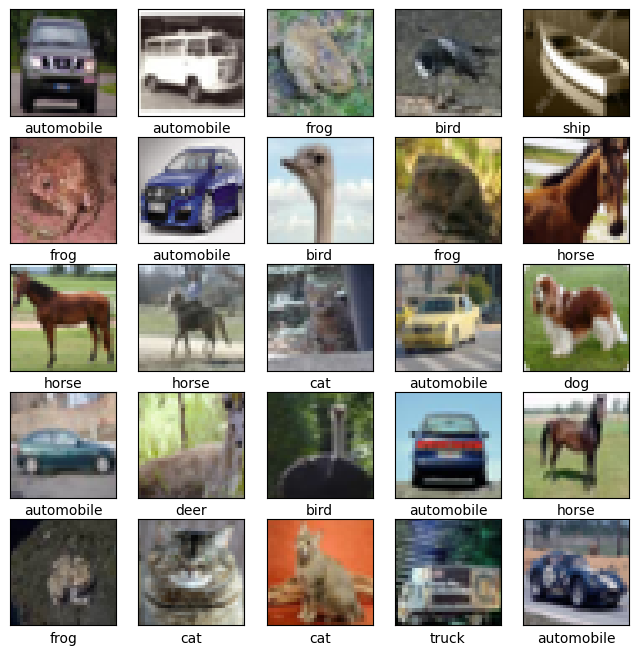

In [ ]:
# Visualize the Dataset
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

Παρατηρουμε οτι οι εικονες ειναι πολυ κακης ποιοτητας, κι αυτο οφειλεται στις πολυ μικρες διαστασεις τους (32x32). Ακομα και για εμας, ειναι δυσκολο να ταξινομησουμε ολες τις εικονες σωστα.

# **CNN**

Λιγα λογια για το CNN σε προβληματα κατηγοριοποιησης πολλαπλων κλασεων.

* Αποτελειται απο συνελικτικα (convolutional, εξου και το ονομα) αλλα και απο fully connected (dense) layers. Ενα συνελικτικο επιπεδο εχει φιλτρα (kernels), τα οποια λειτουργουν σαν νευρωνες ενω οι τιμες τους σαν βαρη. Ετσι, αν ενα φιλτρο εχει διαστασεις (HxWxC)=(3,3,3) τοτε στην ουσια αποτελειται απο 27 βαρη. Αυτα τα φιλτρα, εφαρμοζονται πανω στην εικονα και εκτελουν την πραξη "συσχετιση" ή correlation (ειναι συνελιξη χωρις το φλιπ της εικονας). Αυτη η πραξη, δινει μια νεα εικονα, το λεγομενο **feature map**, το οποιο, με βαση το φιλτρο, διακρινει διαφορα χαρακτηριστικα-μοτιβα. Για παραδειγμα, το φιλτρο:
$$
\begin{bmatrix}
-1 & 1 & 0 \\
-1 & 1 & 0 \\
-1 & 1 & 0
\end{bmatrix}
$$
ανιχνευει κατακορυφες ακμες.

* Στο πρωτο συνελικτικο επιπεδο, τα φιλτρα συνηθως αναγνωριζουν απλα και βασικα σχηματα οπως μικρες οριζοντιες/κατακορυφες γραμμες, διαγωνιες κλπ. Στη συνεχεια, λογω των μη γραμμικων συναρτησεων ενεργοποιησης οπως ReLU, τα βασικα αυτα μοτιβα συνδυαζονται και το δικτυο μαθαινει να αναγνωριζει συνδυασμους τους οπως κυκλους, τριγωνα κ.α. Ετσι, οσο προχωραμε σε βαθος στο δικτυο, ανιχνευονται πολυπλοκα σχηματα οπως ματια, αυτια, χρωματα, υφη κλπ. Η εκπαιδευση και το χτισιμο των βαρων στο φιλτρο ετσι ωστε να διακρινει διαφορα χαρακτηριστικα γινεται μεσω του backpropagation.

* Τα συνελικτικα επιπεδα συνηθως συνοδευονται απο MaxPooling επιπεδα, τα οποια κρατουν τη σημαντικη πληροφορια των feature maps μειωνοντας την αναλυση-διασταση τους ωστε να ελαφρυνει-επιταχυνει το δικτυο. Για παραδειγμα, η εντολη MaxPooling2d(pool_size=(2,2), strides=2) παιρνει το feature map, το σκαναρει σε κελια 2x2 και κραταει τη μεγαλυτερη τιμη του καθε κελιου. Με τις συγκεκριμενες τιμες των παραμετρων της, η MaxPooling μειωνει τις διαστασεις του feature map στο μισο. Ωστοσο, χανει πληροφορια που ισως να ειναι σημαντικη.

* Μετα το τελευταιο Convolutional Layer ακολουθει συνηθως ενα Dense Layer με πολλους νευρωνες, το οποιο βοηθα στη σωστη κατηγοριοποιηση. Επειδη ομως τα συνελικτικα επιπεδα βγαζουν τρισδιαστατη εξοδο: (Height,Width,Channels), και το dense επιπεδο δεχεται 1D εισοδο, μεσολαβει ενα Flatten που κανει αυτη τη μετατροπη.

* Η συναρτηση ενεργοποιησης των επιπεδων μεχρι εδω ειναι συνηθως η ReLU (Rectified Linear Unit):
$$
\
\text{ReLU}(x) =\text{max}(0,x)
\
$$

* Τελος, το τελευταιο επιπεδο ειναι παντα ενα Dense Layer με νευρωνες οσους και οι κλασεις του Dataset. Ο καθενας αντιστοιχει σε μια κλαση. Η συναρτηση ενεργοποιησης αυτου του επιπεδου ειναι η **softmax**, η οποια δινει στην εξοδο ενα διανυσμα πιθανοτητων. Συγκεκριμενα, η εισοδος καθε νευρωνα i στο τελευταιο layer ειναι ο αριθμος:
$$
\
z_i = \mathbf{w}_i^\top \mathbf{x} + b_i
\
$$
Ετσι, οι εισοδοι των νευρονων δημιουργουν το διανυσμα:
$$
\
(z_1, z_2, \ldots, z_{10})
\
$$
τα στοιχεια του οποιου λεγονται **logits**. Η softmax παιρνει ενα-ενα τα logits και τα μετατρεπει σε πιθανοτητες ως εξης:

$$
\
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
\
$$
* Επομενως, η προβλεψη-εξοδος του δικτυου ειναι ενα διανυσμα με στοιχεια που εκφραζουν την πιθανοτητα η αρχικη εικονα να ανηκει στην κατηγορια καθε νευρωνα, της μορφης:
$$
\
(0.01, 0.03, 0.95,0.02,\ldots, 0.05)
\
$$
Η συναρτηση αυτη ειναι ιδανικη γιατι δινει τιμες που αθροιζουν στην μοναδα, και ειναι θετικες, που ειναι απαραιτητα στοιχεια για να εκφραζουν πιθανοτητες. Επισης, συνδυαζεται αψογα με την συναρτηση κοστους categorical crossentropy.

# **Building the Architecture of the CNN Model**
Παμε τωρα να χτισουμε το νευρωνικο μας δικτυο. Η σκεψη μου ειναι:

1. Να προσπαθησω πρωτα να βρω μια καλη αρχιτεκτονικη (καθως ξερουμε οτι αυτη επηρεαζει δραστικα την αποδοση του μοντελου) προσθετοντας layers και αλλαζοντας το πληθος νευρονων ανα layer, διατηρωντας σταθερες τις συνθηκες εκπαιδευσης.
2. Μολις βρω την καλυτερη - πιο αποδοτικη, θα βελτιωσω το μοντελο αλλαζοντας τις εξης υπερπαραμετρους: optimizer, learning rate, epochs, batch size, και χρησιμοποιωντας τεχνικες οπως Batch Normalization, Dropout, Early Stopping, Data Augmentation. Ξεκιναω με την παρακατω πολυ βασικη αρχιτεκτονικη.

 #  **Model 1**


In [ ]:
# Building the CNN Model

model_architecture1= Sequential([
    Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=10, activation='softmax'),
])
# Compile
model_architecture1.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train1 = model_architecture1.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1029 - loss: 2.2992 - val_accuracy: 0.1222 - val_loss: 2.2643
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1388 - loss: 2.2507 - val_accuracy: 0.1778 - val_loss: 2.2014
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2042 - loss: 2.1741 - val_accuracy: 0.2538 - val_loss: 2.0776
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2599 - loss: 2.0544 - val_accuracy: 0.2782 - val_loss: 1.9908
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2939 - loss: 1.9771 - val_accuracy: 0.3106 - val_loss: 1.9426
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3169 - loss: 1.9285 - val_accuracy: 0.3288 - val_loss: 1.8980
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3360 - loss: 1.8871 - val_accuracy: 0.3512 - val_loss: 1.8596
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3414 - loss: 1.8636 - 

Παρατηρουμε οτι το μοντελο μας ειναι πολυ κακο, καθως εχουμε training accuracy 48.4% και μεγιστο validation accuracy κοντα 50%. Δηλαδη ουτε εκπαιδευτηκε καλα ουτε γενικευει καλα - **Underfitting**. Παμε τωρα να βελτιωσουμε το μοντελο μας προσθετοντας περισσοτερα φιλτρα ανα επιπεδο.

# **Model 2**

In [ ]:
model_architecture2= Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=10, activation='softmax'),
])

# Compile
model_architecture2.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train2 = model_architecture2.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1118 - loss: 2.3019 - val_accuracy: 0.1512 - val_loss: 2.2715
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1694 - loss: 2.2524 - val_accuracy: 0.2014 - val_loss: 2.1704
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2329 - loss: 2.1294 - val_accuracy: 0.2816 - val_loss: 2.0207
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2844 - loss: 2.0073 - val_accuracy: 0.3030 - val_loss: 1.9527
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3115 - loss: 1.9452 - val_accuracy: 0.3280 - val_loss: 1.9082
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3370 - loss: 1.8928 - val_accuracy: 0.3526 - val_loss: 1.8518
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3515 - loss: 1.8470 - val_accuracy: 0.3616 - val_loss: 1.8122
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3663 - loss: 1.7930 - 

Βλεπουμε μια πολυ μικρη βελτιωση του δικτυου μας: train acc: 50% -> 53.7%, val acc: 48.4% -> 53%. Τωρα θα ξανα αλλαξουμε το πληθος των φιλτρων των Convolutional layers αλλα και των νευρονων του dense layer.

# **Model 3**

In [ ]:
model_architecture3= Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=10, activation='softmax'),
])
# Compile
model_architecture3.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train3 = model_architecture3.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.1378 - loss: 2.2864 - val_accuracy: 0.2196 - val_loss: 2.2202
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2529 - loss: 2.1786 - val_accuracy: 0.2726 - val_loss: 2.0439
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2920 - loss: 2.0118 - val_accuracy: 0.3016 - val_loss: 1.9452
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3258 - loss: 1.9329 - val_accuracy: 0.3348 - val_loss: 1.8984
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3403 - loss: 1.8882 - val_accuracy: 0.3456 - val_loss: 1.8537
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3595 - loss: 1.8363 - val_accuracy: 0.3620 - val_loss: 1.8142
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3761 - loss: 1.7945 - val_accuracy: 0.3714 - val_loss: 1.7708
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3887 - loss: 1.7532 - 

Βλεπουμε παλι μια μικρη βελτιωση: train acc: 53.7% -> 56.9% , val acc: 53% -> 55%

Παμε τωρα να αυξησουμε κι αλλο τους νευρωνες στο dense layer.

# **Model 4**

In [ ]:
model_architecture4= Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=10, activation='softmax'),
])
# Compile
model_architecture4.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train4 = model_architecture4.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1485 - loss: 2.2741 - val_accuracy: 0.2480 - val_loss: 2.1599
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2470 - loss: 2.1198 - val_accuracy: 0.2940 - val_loss: 2.0017
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2975 - loss: 1.9852 - val_accuracy: 0.3292 - val_loss: 1.9211
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3247 - loss: 1.9180 - val_accuracy: 0.3556 - val_loss: 1.8674
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3442 - loss: 1.8639 - val_accuracy: 0.3558 - val_loss: 1.8363
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3694 - loss: 1.8096 - val_accuracy: 0.3500 - val_loss: 1.8035
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3907 - loss: 1.7515 - val_accuracy: 0.4076 - val_loss: 1.7209
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4070 - loss: 1.7011 - 

Παλι βλεπουμε μια μικρη βελτιωση: train acc: 56.7% -> 58.7% , αλλα μειωση στη γενικευση: val acc: 55% -> 54.9%, οποτε θα μειωσω τους νευρωνες στο dense layer. Παμε να προσθεσουμε και μερικα layers. Θα προσθεσω ενα Convolutional Layer ακομα με 128 φιλτρα.

# **Model 5**

In [ ]:
model_architecture5= Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=10, activation='softmax'),
])
# Compile
model_architecture5.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train5 = model_architecture5.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1180 - loss: 2.2968 - val_accuracy: 0.1840 - val_loss: 2.2740
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1883 - loss: 2.2618 - val_accuracy: 0.2386 - val_loss: 2.2076
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2468 - loss: 2.1729 - val_accuracy: 0.2502 - val_loss: 2.0512
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2777 - loss: 2.0251 - val_accuracy: 0.2902 - val_loss: 1.9679
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3069 - loss: 1.9562 - val_accuracy: 0.3144 - val_loss: 1.9173
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3280 - loss: 1.9057 - val_accuracy: 0.3272 - val_loss: 1.8750
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3460 - loss: 1.8650 - val_accuracy: 0.3458 - val_loss: 1.8247
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3629 - loss: 1.8077 -

# **Model 6**

Θα δοκιμασω διπλα συνελικτικα επιπεδα ανα Block, αφαιρωντας το 128αρι

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1079 - loss: 2.2931 - val_accuracy: 0.2052 - val_loss: 2.2452
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1965 - loss: 2.2025 - val_accuracy: 0.2474 - val_loss: 2.0889
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2841 - loss: 2.0311 - val_accuracy: 0.3100 - val_loss: 1.9319
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3250 - loss: 1.9116 - val_accuracy: 0.3212 - val_loss: 1.9034
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3551 - loss: 1.8317 - val_accuracy: 0.3640 - val_loss: 1.7988
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3784 - loss: 1.7585 - val_accuracy: 0.3716 - val_loss: 1.7771
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4061 - loss: 1.6794 - val_accuracy: 0.4246 - val_loss: 1.6409
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4314 - loss: 1.6072 -

Η καλυτερη αρχιτεκτονικη εως τωρα. Train accuracy: 63.2%, Validation accuracy: 59%

# **Model 7**

Θα προσθεσω αλλο ενα block με δυο 128αρια Convolutional Layers

In [ ]:
model_architecture7 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 3
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=10, activation='softmax')
])

# Compile
model_architecture7.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train7 = model_architecture7.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.1221 - loss: 2.3010 - val_accuracy: 0.1898 - val_loss: 2.2892
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1769 - loss: 2.2820 - val_accuracy: 0.1836 - val_loss: 2.2315
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2030 - loss: 2.1954 - val_accuracy: 0.2108 - val_loss: 2.1351
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2397 - loss: 2.1013 - val_accuracy: 0.1920 - val_loss: 2.1136
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2957 - loss: 1.9810 - val_accuracy: 0.3134 - val_loss: 1.8994
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3440 - loss: 1.8424 - val_accuracy: 0.3462 - val_loss: 1.7976
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3744 - loss: 1.7508 - val_accuracy: 0.3622 - val_loss: 1.7972
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3981 - loss: 1.6890 -

Παρατηρω οτι τα 2 128αρια Convolutional Layers δε βοηθησαν, οποτε θα τα αφαιρεσω. **Θα κρατησω την αρχιτεκτονικη του μοντελου 6, ως την καλυτερη μεχρι τωρα.**

In [ ]:
model_architecture6.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,118,764 (4.27 MB)

 Trainable params: 1,117,866 (4.26 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)

# **Batch Normalization**

Η μεθοδος αυτη αποσκοπει στο να σταθεροποιησει και επιταχυνει την εκπαιδευση μεσω της κανονικοποιησης των τιμων που παραγει το conv layer (δηλαδη τα στοιχεια των feature maps) ωστε να εχουν σταθερη κατανομη (μεση τιμη και διασπορα). Συγκεκριμενα:

Εστω οι τιμες:
$$
\
x_1, x_2, \ldots, x_m
\
$$
Η Batch Normalization υπολογιζει:
* Τη **μεση τιμη**:
$$
\
\mu_B = \frac{1}{m} \sum_{i=1}^m x_i
\
$$
* Τη **διασπορα**:
$$
\
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2
\
$$
Και **κανονικοποιει**:
$$
\
\hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
\
$$
Ετσι, ολα τα feature values εχουν μεση τιμη **0** και διασπορα **1**. Επιπλεον ομως, η Batch Normalization προσθετει δυο trainable παραμετρους:

*   **γ**: κλιση
*   **β**: μετατοπιση

και μετασχηματιζει τις κανονικοποιημενες τιμες:
$$
\
y_i = \gamma \hat{x_i} + \beta
\
$$
Με αυτο τον τροπο το δικτυο μαθαινει πως θελει να ειναι η κατανομη των τιμων, αφου πρωτα τις εχει σταθεροποιησει. Χωρις αυτες, το δικτυο θα περιοριζοταν πολυ, γιατι μπορει για παραδειγμα ενα feature να ειναι χρησιμο μονο αν εχει υψηλη μεση τιμη ή ισως να χρειαζεται μεγαλυτερη διασπορα απο 1. Οι παραμετροι γ και β μαθαινονται απο το δικτυο οπως και τα βαρη και biases, μεσω του backpropagation. Προσοσχη! Ειναι πολυ σημαντικο το Batch Normalization να εφαρμοστει στις τιμες των feature maps **ΠΡΙΝ** μπουν στην ReLU. Αυτο γιατι θελουμε να κανονικοποιησουμε τις raw-ανεπηρεαστες τιμες των feature maps που παρηγαγε το Conv ή το Dense Layer και περιεχουν την πραγματικη πληροφορια για την εικονα, οχι τις τιμες που εχουν αλλοιωθει απο τη συναρτηση ενεργοποιησης.

# **Model 8: Model 6 + Batch Norm**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2888 - loss: 2.0081 - val_accuracy: 0.4628 - val_loss: 1.5029
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4853 - loss: 1.4453 - val_accuracy: 0.5272 - val_loss: 1.3442
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5383 - loss: 1.3048 - val_accuracy: 0.5670 - val_loss: 1.2482
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5727 - loss: 1.2030 - val_accuracy: 0.5648 - val_loss: 1.2090
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6031 - loss: 1.1258 - val_accuracy: 0.5864 - val_loss: 1.1672
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6272 - loss: 1.0767 - val_accuracy: 0.6098 - val_loss: 1.1194
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6428 - loss: 1.0241 - val_accuracy: 0.6050 - val_loss: 1.1632
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6610 - loss: 0.9812

Παρατηρουμε την τεραστια βελτιωση του μοντελου μας που εκανε η τεχνικη αυτη. Το **training accuracy** εκτοξευτηκε απο 63% στο **86%** ενω το **validation accuracy** απο 59% στο **71%**. Μεχρι τωρα, τα μοντελα μας ειχαν αρκετα κακη εκπαιδευση. Η γενικευση τους ηταν επισης κακη, αλλα κυριως λογω της κακης εκπαιδευσης τους. Αυτο το φαινομενο λεγεται underfitting. Τωρα, εχοντας εφαρμοσει τo Batch Normalization, εχουμε μια ακριβεια εκπαιδευσης που αξιζει της προσοχης μας. Δεν εχουμε πλεον τοσο underfitting (υπο-εκπαιδευση). Ωστοσο, βλεπουμε οτι η ακριβεια γενικευσης, παρολο που αρχικα αυξανεται μαζι με την εκπαιδευση, μετα απο ενα σημειο (περιπου στο epoch 6) μενει πισω και αυξανεται ελαχιστα. Το μεγιστο που φτανει ειναι 71%. Αυτο μας δειχνει οτι, παρολο που το μοντελο εκπαιδευτηκε καλα, δεν γενικευει τοσο καλα. Δηλαδη αρχισε να "παπαγαλιζει" λιγο και να μαθαινει καλα μονο τις εικονες που του δειχνουμε, ενω σε εικονες που δεν εχει ξαναδει δεν ειναι τοσο ικανο να τις διακρινει. Εχουμε δηλαδη overfitting.

# **HYPERPARAMETER TUNING: Optimizer**
Ο Optimizer, ειναι υπευθυνος για την ενημερωση των βαρων. Οπως γνωριζουμε απο τη θεωρια, το νευρωνικο δικτυο ειναι στην ουσια ενα προβλημα ελαχιστοποιησης. Το δικτυο κανει προβλεψεις, υπολογιζουμε τα σφαλματα που κανει μεσω μιας συναρτησης κοστους (L: loss function) της επιλογης μας, και προσπαθουμε να ελαχιστοποιησουμε αυτη τη συναρτηση σφαλματος μεσω των ορισματων-παραμετρων της, δηλαδη τα βαρη και τα biases. Αυτο γινεται με τη γνωστη μεθοδο του backpropagation, η οποια υπολογιζει τις παραγωγους της συναρτησης κοστους ως προς καθε βαρος μεσα στο δικτυο. Στην ουσια, το δικτυο ψαχνει να βρει ποσο ευθυνεται ο καθε νευρωνας για το συνολικο σφαλμα (δ_ij). Αν η παραγωγος ως προς καποιο βαρος ειναι θετικη, σημαινει οτι αν αυτο το βαρος αυξηθει, το σφαλμα θα αυξηθει. Αρα το βαρος πρεπει να μειωθει. Ομοιως και αντιστροφα. Αφου το μοντελο εχει κανει το backpropagation μεσω της συναρτησης model.fit και εχει υπολογισει τις παραγωγους της συναρτησης κοστους ως προς ολα τα βαρη, τωρα πρεπει να δουμε πως αυτα θα αλλαχθουν-ενημερωθουν. Προς ποια κατευθυνση θα κινηθουμε δηλαδη. Υπαρχουν διαφοροι βελτιστοποιητες, οι οποιοι ενημερωνουν τα βαρη με διαφορετικους τροπους.

* Αρχικα, υπαρχει το απλο **Gradient Descent**, οπου κινουμαστε προς την κατευθυνση μεγιστης μειωσης της συναρτησης κοστους, δηλαδη πανω στο -grad_L. Η μεθοδος αυτη, παιρνει ολα τα training samples, τα κανει forward-pass, υπολογιζει τα gradients της μεσης Loss ως προς ολα τα βαρη στο ιδιο σημειο w, και ενημερωνει τα βαρη μια φορα ανα epoch. Παρολο που ειναι ακριβης, ειναι υπερβολικα αργη για μεγαλα datasets και απαιτει πολυ μνημη.

* Στη συνεχεια, υπαρχει το **pure SGD** (Stochastic Gradient Descent). Εδω κανουμε forward pass ενα-ενα τα δειγματα, υπολογιζουμε τη loss καθε δειγματος, κανουμε backprop και βρισκουμε το gradient ως προς τα τωρινα βαρη. Μετα ενημερωνουμε μια φορα τα βαρη. Αυτο εισαγει στοχαστικοτητα (θορυβο), επειδη καθε gradient βασιζεται σε διαφορετικο δειγμα και σε ελαφρως διαφορετικα βαρη.

* Το **mini-batch SGD** κανει το ιδιο με το Pure SGD, απλα εκτελει backpropagation και ενημερωνει τα βαρη μετα απο το forward-pass καθε batch. Τα batches ειναι πολυ αποτελεσματικη τεχνικη ειδικα για τις GPU οι οποιες κανουν παραλληλους υπολογισμους, και ακομα κι αν εισαγουν λιγο θορυβο συγκλινει πολυ πιο γρηγορα. Γι'αυτο εχει επικρατησει σημερα. Στα μοντελα μοου μεχρι τωρα χρησιμοποιουσα SGD optimizer με mini-batches.

Τελος, ο optimizer που χρησιμοποιειται παντου σημερα ειναι ο **Adam (Adaptive moments Estimation)**. Το στοιχειο που χαρακτηριζει αυτον τον optimizer ειναι η προσαρμοστικοτητα του (adaptivity). Ο Adam προσαρμοζει το learning rate του, καθε στιγμη και για καθε βαρος. Χρησιμοποοιει δυο τεχνικες.

* Πρωτα απ'ολα , χρησιμοποιει **momentum** (ορμη):
Αυτο που κανει το momentum ειναι στην ουσια να επιταχυνει προς τη σωστη κατευθυνση. Δηλαδη αν η κατευθυνση κινησης ειναι σταθερη για μερικα βηματα, τοτε επιταχυνε προς αυτην γιατι μαλον ειναι η σωστη. Το πετυχαινει με την αναδρομικη σχεση:
$$
\
M_t = \beta_1 M_{t-1} + (1 - \beta_1)\, g_t,
\quad \text{όπου } g_t = \nabla L(W_t)
\
$$
οπου βλεπουμε οτι το momentum ειναι στην ουσια ενα exponential moving average του gradient του Wt αφου αν αντικαταστησουμε προκυπτει:
$$
\
M_t
= \beta_1\bigl(\beta_1 M_{t-2} + (1 - \beta_1)g_{t-1})
+ (1 - \beta_1)g_t= \beta_1^2 M_{t-2} + \beta_1(1-\beta_1)g_{t-1}
+ (1 - \beta_1)g_t
\
$$
 Και αναδρομικα προκυπτει:
$$
\
M_t
= (1-\beta_1)\bigl(g_t+ \beta_1 g_{t-1}+ \beta_1^2 g_{t-2}+ \beta_1^3 g_{t-3}
+ \cdots \bigr)
\
$$
Βλεπουμε οτι το momentum ειναι διανυσμα, που προκυπτει ως **γραμμικος συνδυασμος** των gradients. Το β1 ειναι υπερπαραμετρος και συνηθως ειναι ιση με 0.9. Ετσι, οι συντελεστες των προηγουμενων gradient φθινουν εκθετικα. Αυτη η ιδιοτητα της "μνημης", καταφερνει το εξης:
Εαν πολλαπλα gradients εχουν παρομοια κατευθυνση, τοτε επιταχυνε προς τα εκει. Το momentum vector μεγαλωνει σε μηκος, κανουμε μεγαλυτερα βηματα, και αρα συγκλινουμε πιο γρηγορα στο ελαχιστο της loss function:
$$
\
\mathbf{W}_{t+1} = \mathbf{W}_t - \eta\, \mathbf{m}_t
\
$$
* Δευτερον, χρησιμοποιει **RMSprop (Root Mean Square)**:
$$
\
u_t = \beta_2\, u_{t-1} + (1 - \beta_2)\, g_{t}^2
\
$$
οπου το τετραγωνο εφαρμοζεται element-wise στα στοιχεια του gradient του Wt, και το β2 ειναι υπερπαραμετρος που συνηθως ισουται με 0.99. Παρατηρουμε οτι μοιαζει με το Momentum αλλα με τα τετραγωνα των gradients.  Ενημερωνει τα βαρη ως εξης:
$$
\
W_{t+1}=W_t-\eta \frac{\nabla L(W_t)}{\sqrt{u_{t}} + \epsilon}
\
$$
Οσο πιο μεγαλα τα gradients, τοσο μεγαλωνει το u_t, αρα τοσο μικραινει ο παρονομαστης και κατα συνεπεια το βημα που κανω, και αντιστροφα. Ετσι, αυτο που πετυχαινει το RMSprop ειναι να ρυθμιζει ποσο μεγαλο βημα κανουμε.

Παμε να δουμε τωρα τον Adam. Ο Adam κανει συνδυασμο του momentum και RMSprop. Ας δουμε τα μαθηματικα για ενα βαρος Wi:
$$
\
\begin{array}{lll}
\textbf{Momentum:} &
m_{t,i} = \beta_1 m_{t-1,i} + (1 - \beta_1)\, \dfrac{\partial L}{\partial W_{i,t} } & (1)
\\[10pt]
\textbf{RMSprop:} &
u_{t,i} = \beta_2 u_{t-1,i} + (1 - \beta_2)\left(\dfrac{\partial L}{\partial W_{i,t} }\right)^2 & (2)
\\[10pt]
\textbf{Bias corrections:} &
\hat{m}_{t,i} = \frac{m_{t,i}}{1 - \beta_1^{t}},\quad
\hat{u}_{t,i} = \frac{u_{t,i}}{1 - \beta_2^{t}}
& (3)
\\[10pt]
\textbf{Weights update:} &
W_{i,t+1}
=
W_{i,t}
-
\eta\,\frac{\hat{m}_{t,i}}{\sqrt{\hat{u}_{t,i}} + \epsilon}
& (4)
\end{array}
\
$$

Οπως ειπαμε η 1η εξισωση ειναι το momentum που μειωνει το ζικ-ζακ και επιταχυνει στις σωστες κατευθυνσεις, και η 2η ειναι το RMSprop που ρυθμιζει το learning rate για καθε βαρος ξεχωριστα (adaptive LR). Μεγαλο u_t -> μικρο βημα, μικρο u_t -> μεγαλο βημα. Η 3η εξισωση ειναι τα bias corrections. Επειδη στην αρχη τα m_t και u_t ειναι πολυ μικρα γιατι δεν εχουν μεγαλη μνημη, οι διορθωσεις αυτες εξασφαλιζουν οτι τα πρωτα βηματα θα ειναι σωστα και οχι πολυ μικρα. Στην 4η εξισωση βλεπουμε την ενημερωση των βαρων. Παρατηρουμε οτι στον Adam, το καθε βαρος εχει το δικο του learning rate:
$$
\
\eta_{i,\mathrm{eff}}
=
\frac{\eta}{\sqrt{\hat{u}_{t,i}} + \epsilon}
\
$$
και αυτο υπολογιζει ο Adam εσωτερικα. Το learning rate που του δινω εγω ειναι το η, οχι το η_eff. Εγω του δινω απλα ενα "base" learning rate. Και επειδη ακριβως ο ρυθμος μαθησης προσαρμοζεται σε καθε βαρος, ο Adam δεν επηρεαζεται τοσο απο αλλαγες στο learning rate οσο αλλοι optimizers.

Προσοχη!! Στην εξισωση 4 βλεπουμε την ενημερωση ενος συγκεκριμενου βαρους. Κανονικα, το συνολικο βαρος ενος δικτυου ειναι ενας πινακας. Επομενως προκειμενου να γινει η ενημερωση, πρεπει ο δευτερος παραγοντας στο δεξι μελος μετα το μειον, να ειναι πινακας ιδιων διαστασεων. Γι'αυτο το λογο, το momentum και το RMSprop πρεπει να παιρνουν τοσες τιμες οσες και τα βαρη. Στην ουσια ολες οι εξισωσεις και καθε πραξη εντος αυτων υπολογιζονται element-wise, δηλαδη για καθε στοιχειο των πινακων των βαρων W, momentum m, και RMS u. Εχει αποδειχθει σε πολλα papers οτι ο Adam κυριαρχει ως optimizer, βεβαια αρκετα κοντα στον RMSprop.

Παμε τωρα να δοκιμασουμε διαφορους optimizers για το μοντελο μας. Μεχρι τωρα χρησιμοποιουσα SGD.

# **Model 9: Arch 6 + Batch Norm + SGD with Momentum**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4425 - loss: 1.5723 - val_accuracy: 0.6144 - val_loss: 1.1077
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6560 - loss: 0.9879 - val_accuracy: 0.6548 - val_loss: 0.9848
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7234 - loss: 0.7973 - val_accuracy: 0.6312 - val_loss: 1.0537
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7781 - loss: 0.6542 - val_accuracy: 0.6990 - val_loss: 0.8645
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8128 - loss: 0.5626 - val_accuracy: 0.7136 - val_loss: 0.8274
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8404 - loss: 0.4811 - val_accuracy: 0.7256 - val_loss: 0.8227
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8713 - loss: 0.4073 - val_accuracy: 0.7374 - val_loss: 0.7885
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8963 - loss: 0.3401 

Παρατηρουμε την εκτοξευση του training accuracy, με την απλη προσθηκη του momentum. Η ακριβεια ανεβηκε κατα 13% και εχει φτασει σχεδον το 100%, ενω η ακριβεια γενικευσης πηγε απο 71% στο 75%. Το μοντελο εμαθε τελεια τα δεδομενα εκπαιδευσης του, χωρις ομως παλι να γενικευει καλα. Εντονο overfitting. Εφοσον εμφανιστηκε αυτο το overfitting εδω, θα κανω μια παυση στο tuning, και θα προσπαθησω να ανεβασω το validation accuracy ωστε να πεσει η υπερκπαιδευση.

# **Reguralization - Dropout**
Η τεχνικη αυτη απενεργοποιει τυχαια καποιους νευρωνες-φιλτρα κατα τη διαρκεια της εκπαιδευσης, ωστε να μην επιτρεψει στο μοντελο να μαθει να εξαρταται εντονα απο συγκεκριμενους νευρωνες (δηλαδη αποτρεπει τη δημιουργια μεγαλων βαρων σε αυτους), και ετσι οι υπολοιποι νευρωνες μαθαινουν να αναπληρωνουν την απουσια τους, μαθαινοντας κι αυτοι παρομοια χαρακτηριστικα. Ετσι τα βαρη κατανεμονται με πιο σωστο τροπο στο layer. Προσοχη! Οι Reguralization τεχνικες στοχευουν να βελτιωσουν τη γενικευση και να ριξουν το overfitting, οχι να βελτιωσουν την εκπαιδευση!


# **Model 10: Arch 6 + Batch Norm + SGD with Momentum + Dropout** (πριν το Dense(256))
Θα χρησιμοποιησω Dropout μετα το Flatten layer με rate = 0.5, δηλαδη το δικτυο απενεργοποιει-μηδενιζει τυχαια τα μισα στοιχεια του Flatten. Ας δουμε ποσα στοιχεια εχει το Flatten επειδη το σκεφτομουν.

Στην αρχη η εισοδος των εικονων ειναι (32,32,3) οπου 3 τα καναλι RGB και 32x32 η αναλυση (πιξελς) της εικονας. Στο 1ο block τα συνελικτικα επιπεδα εχουν 32 φιλτρα, τα οποια παραγουν 1 2D feature map το καθενα. Λογω του padding='same' που βαλαμε, κανουν zero padding στην εικονα τετοιο ωστε η διασταση της εξοδου καθε φιλτρου - δηλαδη του feature map να ειναι ιδια. Επειδη η συσχετιση που κανουν τα φιλτρα ειναι τετοια ωστε παντα ολο το φιλτρο να πεφτει πανω στην εικονα και κανενα στοιχειο του να μη πεφτει εξω, η εξοδος που δινουν εχει (N-F+1)x(N-F+1) = (32-3+1)x(32-3+1) = 30x30, οπου F η διασταση του φιλτρου. Αρα για να γινει η εξοδος 32x32 πρεπει το zero padding να προσθεσει 2 γραμμες και 2 στηλες με μηδενικα στην εισοδο. Επομενως, καθε φιλτρο παραγει ενα 32x32 feature map. Εχουμε 32 φιλτρα αρα η συνολικη εξοδος του 1ου συνελικτικου επιπεδου θα ειναι (32,32,32). Την ιδια ακριβως εξοδο θα εχει και το 2ο συνελικτικο επιπεδο γιατι εχει κι αυτο 32 φιλτρα.

Καθε 32x32 καναλι μπαινει σε MaxPool, που οπως ειπαμε στην παραγραφο CNN, μειωνει τις διαστασεις του στο μισο. Αρα δινει εξοδο (16,16,32).

Αυτη μπαινει στα 2 επομενα Convolutional που δινουν (16,16,64) γιατι εχουν 64 φιλτρα, και με τη σειρα του στο MaxPool που δινει (8,8,64).

Αυτο ειναι που παιρνει το Flatten, και το κανει 1D vector με 8x8x64 = 4096 στοιχεια. Μπορουμε να το επιβεβαιωσουμε και στο model.summary παραπανω.

Επομενως, το Dropout με ρυθμο 0.5 απενεργοποιει-μηδενιζει τυχαια 4096/2 = 2048 στοιχεια του flatten σε καθε batch.

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.3477 - loss: 1.8259 - val_accuracy: 0.5628 - val_loss: 1.2343
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5546 - loss: 1.2454 - val_accuracy: 0.6176 - val_loss: 1.0791
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6232 - loss: 1.0662 - val_accuracy: 0.6372 - val_loss: 1.0062
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6575 - loss: 0.9629 - val_accuracy: 0.6850 - val_loss: 0.9102
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6821 - loss: 0.9061 - val_accuracy: 0.6730 - val_loss: 0.9088
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7025 - loss: 0.8487 - val_accuracy: 0.7122 - val_loss: 0.8101
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7183 - loss: 0.7946 - val_accuracy: 0.7188 - val_loss: 0.8106
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7343 - loss: 0.7498 -

Παρατηρουμε οτι το Dropout προλαβαινει το overfitting! Η εκπαιδευση σταματησε στο 86% ενω** η γενικευση ανεβηκε στο 80%** ! Τωρα θα δοκιμασω να εφαρμοσω διπλο Dropout.

# **Model 11: Arch 6 + Batch Norm + SGD with Momentum + Dropout** (πριν και μετα το Dense(256))

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.3015 - loss: 2.0662 - val_accuracy: 0.4900 - val_loss: 1.4247
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4824 - loss: 1.4187 - val_accuracy: 0.5216 - val_loss: 1.3539
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5376 - loss: 1.2738 - val_accuracy: 0.5840 - val_loss: 1.1616
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5864 - loss: 1.1469 - val_accuracy: 0.6608 - val_loss: 0.9640
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6191 - loss: 1.0698 - val_accuracy: 0.6112 - val_loss: 1.0942
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6382 - loss: 1.0142 - val_accuracy: 0.6944 - val_loss: 0.8567
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6562 - loss: 0.9628 - val_accuracy: 0.7010 - val_loss: 0.8570
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6732 - loss: 0.9286 -

Το διπλο Dropout πριν και μετα το Dense Layer δε βοηθησε. Μαλιστα η εκπαιδευση επεσε κατα 7% και η γενικευση κατα 3%, επειδη απενεργοποιησαμε παραπανω νευρωνες απ'οτι το μοντελο χρειαζεται για να μαθει καλα (underfitting). Οποτε κραταω το **model 10**.

# **Reguralization - L2**

Ειπαμε οτι το Dropout απενεργοποιει μερικους νευρωνες εντελως προκειμενου να αποτρεψει τη δημιουργια μεγαλων βαρων. Σε αντιθεση με αυτο, ο L2 δεν απενεργοποιει κανενα νευρωνα, αλλα πιεζει τα βαρη ολων προς το μηδεν. Αυτο το κανει προσθετοντας ποινη στα μεγαλα βαρη, με τον εξης τροπο:
$$
\
L_{\text{total}}(\mathbf{w}) = L_{\text{data}}(\mathbf{w})
+ \lambda \sum_{i=1}^{N} w_i^2
\
$$

**όπου:**

- $L_{\text{data}}(\mathbf{w})$: το συνολικό σφάλμα πρόβλεψης του μοντέλου (data loss)  
- $\lambda \sum_{i=1}^{N} w_i^2$: η ποινή του L2 regularization (weight decay)

Ετσι, οσο πιο μεγαλο γινεται καποιο βαρος, τοσο αυξανει το συνολικο loss. Οποτε στη βελτιστοποιηση, ο optimizer σπρωχνει τα βαρη προς μικροτερες τιμες. Το λ ειναι υπερπαραμετρος που καθοριζει ποση ποινη δινει ο L2 στα βαρη. Οσο πιο μεγαλο, τοσο μεγαλυτερη η ποινη, οποτε τοσο περισσοτερο ο optimizer πιεζει τα βαρη να μικρυνουν.

# **Model 12: Arch 6 + Batch Norm + SGD with Momentum + L2 Reguralization**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256, kernel_regularizer=l2(1e-4)),    # L2
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.2974 - loss: 2.1098 - val_accuracy: 0.3824 - val_loss: 1.8903
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4939 - loss: 1.4429 - val_accuracy: 0.5500 - val_loss: 1.3252
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5525 - loss: 1.2867 - val_accuracy: 0.6178 - val_loss: 1.1041
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5964 - loss: 1.1844 - val_accuracy: 0.6636 - val_loss: 1.0010
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6261 - loss: 1.0974 - val_accuracy: 0.6586 - val_loss: 1.0123
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6399 - loss: 1.0556 - val_accuracy: 0.6776 - val_loss: 0.9669
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6619 - loss: 1.0015 - val_accuracy: 0.6366 - val_loss: 1.0326
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6676 - loss: 0.9800 -

Βλεπουμε οτι ο L2 εφερε κι αυτος βελτιωση στο δικτυο, καθως η γενικευση ανεβηκε απο 74% χωρις αυτον σε 80%,, αλλα εκοψε πολυ την εκπαιδευση συγκριτικα με το Dropout. Αυτο μαλλον συνεβη επειδη το λ που διαλεξα μαλλον ηταν πολυ μεγαλο. Με μικροτερη τιμη λογικα θα δινει καλυτερα αποτελεσματα, αλλα για εξοιονομηση χρονου και επειδη το Dropout βγαζει μια χαρα αποτελεσματα, θα κρατησω το **μοντελο 10**. Παμε τωρα να συνεχισουμε με τη βελτιωση του μοντελου μεσω των υπερπαραμετρων.

# **Hyperparameter Tuning: Optimizer**
# **Model 13 - Arch 6 + Batch Norm + Adam + Dropout**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4596 - loss: 1.5149 - val_accuracy: 0.6154 - val_loss: 1.0796
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6764 - loss: 0.9150 - val_accuracy: 0.6442 - val_loss: 1.0241
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7307 - loss: 0.7618 - val_accuracy: 0.7224 - val_loss: 0.7798
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7628 - loss: 0.6796 - val_accuracy: 0.7178 - val_loss: 0.8182
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7881 - loss: 0.5957 - val_accuracy: 0.7252 - val_loss: 0.7918
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8093 - loss: 0.5405 - val_accuracy: 0.7816 - val_loss: 0.6375
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8274 - loss: 0.4920 - val_accuracy: 0.7752 - val_loss: 0.6491
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8415 - loss: 0.4523 

Βλεπουμε οτι ο Adam ανεβασε πολυ την εκπαιδευση σε σχεση με το SGD+momentum, απο 86% -> 91%, ενω το μεγιστο validation accuracy πηγε 81% -> 83.58%

# **Hyperparameter Tuning: Learning Rate**
Παμε τωρα να παιξουμε με το learning rate. Περα απο την 0.001 που ειχαμε μεχρι τωρα, θα δοκιμασω τις τιμες: 0.0005, 0.005, 0.01, 0.1 και τα αποτελεσματα του καθε μοντελου θα συγκριθουν με αυτο του 0.001 learning rate.

# **Model 14: Model 13 with LR = 0.0005**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.4421 - loss: 1.5647 - val_accuracy: 0.6370 - val_loss: 0.9944
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6567 - loss: 0.9708 - val_accuracy: 0.6738 - val_loss: 0.9112
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7161 - loss: 0.8051 - val_accuracy: 0.7428 - val_loss: 0.7337
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7502 - loss: 0.7106 - val_accuracy: 0.7464 - val_loss: 0.7314
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7748 - loss: 0.6421 - val_accuracy: 0.7296 - val_loss: 0.7582
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7941 - loss: 0.5928 - val_accuracy: 0.7828 - val_loss: 0.6115
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8126 - loss: 0.5316 - val_accuracy: 0.7974 - val_loss: 0.5848
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8280 - loss: 0.4923 

Απειροστη μειωση στην εκπαιδευση 95% (-0.03%) και αυξηση στη γενικευση max val_accuracy: 83.9%(+0.3%). Βλεπουμε επισης λιγο καλυτερα losses στο validation, με τιμες γυρω απο το 0.54.

# **Model 15: Model 13 with LR = 0.005**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.4483 - loss: 1.5665 - val_accuracy: 0.6174 - val_loss: 1.0904
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6787 - loss: 0.9080 - val_accuracy: 0.6618 - val_loss: 0.9896
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7356 - loss: 0.7506 - val_accuracy: 0.7346 - val_loss: 0.7649
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7681 - loss: 0.6574 - val_accuracy: 0.5988 - val_loss: 1.2164
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7916 - loss: 0.5858 - val_accuracy: 0.6918 - val_loss: 0.9103
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8202 - loss: 0.5212 - val_accuracy: 0.7338 - val_loss: 0.7784
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8343 - loss: 0.4687 - val_accuracy: 0.7690 - val_loss: 0.6746
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8461 - loss: 0.4291

Η εκπαιδευση επεσε λιγο 93.8% (-1.5%), οπως και η γενικευση 82.2% (-1.4%).

# **Model 16: Model 13 with LR = 0.01**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.4343 - loss: 1.6099 - val_accuracy: 0.5848 - val_loss: 1.2046
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6606 - loss: 0.9694 - val_accuracy: 0.6198 - val_loss: 1.0617
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7154 - loss: 0.8143 - val_accuracy: 0.5676 - val_loss: 1.3896
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7489 - loss: 0.7115 - val_accuracy: 0.6720 - val_loss: 0.9831
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7735 - loss: 0.6463 - val_accuracy: 0.6864 - val_loss: 0.9019
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7887 - loss: 0.6024 - val_accuracy: 0.7650 - val_loss: 0.6596
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8075 - loss: 0.5551 - val_accuracy: 0.7800 - val_loss: 0.6365
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8203 - loss: 0.5102 -

Η εκπαιδευση χαλασε κι αλλο, ωστοσο παραδοξως η μεγιστη ακριβεια γενικευσης ανεβηκε λιγο. Ωστοσο παλι το μοντελο ειναι χειροτερο απο το αρχικο.

# **Model 17: Model 13 with LR = 0.1**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2969 - loss: 2.0226 - val_accuracy: 0.2804 - val_loss: 2.7497
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5054 - loss: 1.3598 - val_accuracy: 0.5132 - val_loss: 1.4023
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5603 - loss: 1.2245 - val_accuracy: 0.5890 - val_loss: 1.1475
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5961 - loss: 1.1409 - val_accuracy: 0.5742 - val_loss: 1.2040
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6191 - loss: 1.0753 - val_accuracy: 0.5222 - val_loss: 1.3788
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6361 - loss: 1.0449 - val_accuracy: 0.6302 - val_loss: 1.0155
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6533 - loss: 0.9862 - val_accuracy: 0.4238 - val_loss: 1.8408
Epoch 8/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6597 - loss: 0.9710 -

Βλεπουμε οτι η εκπαιδευση και η γενικευση επεσαν πολυ (underfitting). Αυτο συμβαινει γιατι κανουμε πολυ μεγαλα βηματα, χανοντας τα βελτιστα σημεια (τοπικα/ολικα ελαχιστα). Μετα απο αυτα τα πειραματα εχουμε τα εξης: Ολες οι τιμες που δοκιμασα πανω απο το 0.001 εδωσαν χειροτερα αποτελεσμα, με το 0.1 να προκαλει υποεκπαιδευση. Οι ρυθμοι 0.001 και 0.0005 εδωσα παρα πολυ κοντινα αποτελεσματα, με το 0.001 να εχει ελαχιστα καλυτερη εκπαιδευση αλλα χειροτερη γενικευση. Λογω καλυτερης γενικευσης, θα διαλεξω το **μοντελο 14** με LR = 0.0005. **Απο δω και μπρος θα δουλεψω πανω σε αυτο πειραζοντας batch size και epochs, οποτε θα αναγραφω το νεο μοντελο στον τιτλο ως το 14 συν αυτο που αλλαξα.**

# **Hyperparameter Tuning: Batch Size**
Τωρα θα πειραματιστω με το batch_size, το μεγεθος δηλαδη των batches (ομαδων) που το μοοντελο κανει forward pass τα δεδομενα. Με τη μεθοδο των mini batches, καταφερνουμε το εξης: Ολα τα δειγματα του batch περνιουνται με τα ιδια βαρη. Υπολογιζεται το Loss καθε δειγματος, και το συνολικο batch loss ως ο μεσος ορος τους. Μετα το μοντελο κανει backpropagation πανω στο batch Loss, βρισκει το gradient ως προς καθε βαρος, και ο optimizer τα ενημερωνει. Αυτο εισαγει στοχαστικοτητα, επειδη καθε batch gradient υπολογιζεται ως προς διαφορετικα δειγματα (τα οποια ανακατευονται και τυχαια καθε φορα που τρεχω το μοντελο) και διαφορετικα βαρη. Οσο πιο μικρο το batch, τοσο περισσοτερη "στοχαστικοτητα" εισαγεται αφου τα βαρη ενημερωνονται-αλλαζουν περισσοτερες φορες. Εχει αποδειχθει οτι αυτη η στοχαστικοτητα βοηθαει στην ικανοτητα γενικευσης του μοντελου. Ωστοσο, μικροτερο batch συνεπαγεται πιο αργη εκπαιδευση. Οι Batch size τιμες που θα δοκιμασω ειναι 64,128,1024. Δοκιμασα και 16 αλλα δε θα το συμπεριλαβω.

# **Model 18: Model 14 with Batch_size = 64**

In [ ]:
model_architecture6 = Sequential([
    Input(shape=(32,32,3)),       # εβαλα το input ως 1o layer για να φυγει το warning που μου εβγαζε

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.4315 - loss: 1.5960 - val_accuracy: 0.6256 - val_loss: 1.0436
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6479 - loss: 0.9958 - val_accuracy: 0.6732 - val_loss: 0.9297
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7076 - loss: 0.8245 - val_accuracy: 0.6962 - val_loss: 0.8583
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7453 - loss: 0.7278 - val_accuracy: 0.7330 - val_loss: 0.7574
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7701 - loss: 0.6592 - val_accuracy: 0.7514 - val_loss: 0.7028
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7880 - loss: 0.6029 - val_accuracy: 0.7658 - val_loss: 0.6587
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8101 - loss: 0.5428 - val_accuracy: 0.7816 - val_loss: 0.6191
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8244 - loss: 0.5040 - val_accuracy: 

Παρατηρουμε οτι η εκπαιδευση αυξηθηκε πολυ λιγο απο 95% σε 95,6 % ενω η γενικευση επεσε απο 83.9% σε 83.3%. Η εκπαιδευση αυξηθηκε διοτι το gradient ανα batch ειναι τωρα μεσος ορος 64ων gradients δειγματων οποτε ειναι λιγο πιο κοντα στο "ιδανικο" full batch gradient (λιγοτερο στοχαστικο), με μικρο κοστος ομως στο reguralization. Ωστοσο, παρατηρουμε οτι ο χρονος ανα epoch μειωθηκε αρκετα, κι αυτο γιατι κανουμε forward pass σε ομαδες των 64 και οχι των 32, αρα εχουμε λιγοτερα batches και λογω της παραλληλοποιησης που κανει η GPU ανα batch, γλιτωνουμε χρονο.  

# **Model 19: Model 14 with Batch_size = 128**

In [ ]:
model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.4239 - loss: 1.6184 - val_accuracy: 0.2416 - val_loss: 2.6245
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6435 - loss: 1.0064 - val_accuracy: 0.6356 - val_loss: 1.0264
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7093 - loss: 0.8323 - val_accuracy: 0.6834 - val_loss: 0.9240
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7357 - loss: 0.7487 - val_accuracy: 0.6958 - val_loss: 0.8343
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7651 - loss: 0.6682 - val_accuracy: 0.7392 - val_loss: 0.7564
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7831 - loss: 0.6195 - val_accuracy: 0.7744 - val_loss: 0.6357
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8044 - loss: 0.5628 - val_accuracy: 0.7618 - val_loss: 0.6788
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8160 - loss: 0.5274 - val_acc

Παρατηρουμε πως επεσε κι αλλο ο χρονος ανα epoch. Η εκπαιδευση ανεβηκε λιγο ακομα στο 96%, ομως η γενικευση επεσε κι αλλο στο 82.5% επειδη χανουμε σε στοχαστικοτητα οπως εξηγησαμε παραπανω.

# **Model 20: Model 14 with Batch size = 1024**

In [ ]:
model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=1024, epochs=30, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - accuracy: 0.3320 - loss: 1.9187 - val_accuracy: 0.1000 - val_loss: 2.8348
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5472 - loss: 1.2652 - val_accuracy: 0.1000 - val_loss: 3.3620
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.6120 - loss: 1.0953 - val_accuracy: 0.1140 - val_loss: 3.2916
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.6563 - loss: 0.9764 - val_accuracy: 0.1374 - val_loss: 3.0846
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.6831 - loss: 0.9019 - val_accuracy: 0.2276 - val_loss: 2.7559
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.7070 - loss: 0.8369 - val_accuracy: 0.2286 - val_loss: 2.6326
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7341 - loss: 0.7731 - val_accuracy: 0.3162 - val_loss: 2.2163
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.7464 - loss: 0.7224 - val_accuracy: 0.3956 -

Εδω βλεπουμε οτι η γενικευση χαλασε πολυ περισσοτερο απο 82.5% σε 79.7%. Ωστοσο βλεπουμε και μια μεγαλη μειωση στο training accuracy απο 96% σε 90%. Αυτο συμβαινει γιατι τα βαρη ενημερωνονται πολυ λιγοτερες φορες ανα epoch, με αποτελεσμα το δικτυο να μην προλαβαινει να μαθει καλα το training set. Αν ανεβασω τα epochs, θα ανεβει και η εκπαιδευση. Ο χρονος ανα epoch επεσε ενα δευτερολεπτο, παρα τη μεγαλη αυξηση του batch size. Παρατηρουμε δηλαδη οτι μετα απο ενα σημειο υπαρχει ενας κορεσμος της GPU στο χρονο υπολογισμων. Ως καλυτερο μοντελο, θα κρατησω το αρχικο **μοντελο 13** με batch size = 32 καθως ειχε τη μεγαλυτερη γενικευση και ελαχιστα μικροτερη εκπαιδευση.

# **Hyperparameter tuning: Epochs**
Οι εποχες ειναι το ποσες φορες περναμε ολα τα δεδομενα απο το δικτυο. Ανα μια εποχη, εχει περασει 1 φορα ολοκληρο το dataset απο το δικτυο. Σε καθε εποχη, αναλογα με το batch size, γινονται updates των βαρων. Για παραδειγμα, με batch size = 32 και με δεδομενο οτι εχουμε 50.000 δειγματα απο τα οποια τα 45.000 χρησιμοποιουνται για εκπαιδευση και τα 5.000 για validation, εχουμε:
$$
\
\text{Updates per epoch}
= \left\lceil \frac{45000}{32} \right\rceil
= \left\lceil 1406.25 \right\rceil
= 1407
\
$$
το οποιο μπορουμε να επαληθευσουμε αν κοιταξουμε στο log της εκπαιδευσης τον αριθμο που γραφει κατω απο καθε Epoch (1407/1407). Αυτα ειναι το πληθος των batches και επειδη κανουμε 1 update ανα batch, εκφραζουν και το πληθος των updates ανα εποχη. Οσο ανεβαζουμε λοιπον το πληθος των εποχων, κανουμε περισσοτερα updates στα βαρη, αρα αναμενουμε καλυτερα αποτελεσματα, και αντιστροφα. Θα δοκιμασω 20 και 50 εποχες.

# **Model 21: Model 14 with 20 Epochs**

In [ ]:
model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.4430 - loss: 1.5731 - val_accuracy: 0.6238 - val_loss: 1.0534
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6469 - loss: 0.9974 - val_accuracy: 0.6560 - val_loss: 0.9716
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7025 - loss: 0.8286 - val_accuracy: 0.7198 - val_loss: 0.8005
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7469 - loss: 0.7212 - val_accuracy: 0.7434 - val_loss: 0.7413
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7658 - loss: 0.6645 - val_accuracy: 0.7650 - val_loss: 0.6868
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7915 - loss: 0.5939 - val_accuracy: 0.7490 - val_loss: 0.7102
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8066 - loss: 0.5479 - val_accuracy: 0.7488 - val_loss: 0.7257
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8245 - loss: 0.4974 -

Οπως περιμεναμε, λογω λιγοτερων εποχων και αρα ενημερωσεων των βαρων, το μοντελο δεν προλαβε να φτασει την καλυτερη αποδοση του.

# **Model 22: Model 14 with 50 epochs**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), shuffle = True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.4469 - loss: 1.5643 - val_accuracy: 0.6560 - val_loss: 0.9822
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6583 - loss: 0.9635 - val_accuracy: 0.6764 - val_loss: 0.8997
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7169 - loss: 0.8053 - val_accuracy: 0.7162 - val_loss: 0.8036
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7459 - loss: 0.7233 - val_accuracy: 0.6968 - val_loss: 0.8401
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7680 - loss: 0.6505 - val_accuracy: 0.7346 - val_loss: 0.7467
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7923 - loss: 0.5873 - val_accuracy: 0.7686 - val_loss: 0.6501
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8144 - loss: 0.5285 - val_accuracy: 0.7716 - val_loss: 0.6624
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8278 - loss: 0.4929 

Βλεπουμε μικρη βελτιωση στην εκπαιδευση και στη γενικευση απο το μοντελο 14 με τις 30 εποχες εκπαιδευσης. Συγκεκριμενα: Train: 95% -> 96.8% , max_al_acc: 83.9% -> 84.36%, βεβαια το loss ανεβηκε ελαχιστα παλι γυρω στο 0.6.

# **Model 23: Model 14 with 85 Epochs**

In [ ]:
model_architecture6 = Sequential([
    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=85, validation_data=(x_val,y_val), shuffle = True)

Epoch 1/85
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.4448 - loss: 1.5655 - val_accuracy: 0.6148 - val_loss: 1.0882
Epoch 2/85
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6525 - loss: 0.9803 - val_accuracy: 0.7016 - val_loss: 0.8505
Epoch 3/85
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7114 - loss: 0.8101 - val_accuracy: 0.7338 - val_loss: 0.7541
Epoch 4/85
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7471 - loss: 0.7191 - val_accuracy: 0.6994 - val_loss: 0.8539
Epoch 5/85
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7728 - loss: 0.6511 - val_accuracy: 0.7556 - val_loss: 0.6883
Epoch 6/85
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7914 - loss: 0.5933 - val_accuracy: 0.7776 - val_loss: 0.6272
Epoch 7/85
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8114 - loss: 0.5369 - val_accuracy: 0.7766 - val_loss: 0.6574
Epoch 8/85
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8228 - loss: 0.5032 -

Εδω φαινεται ξεκαθαρα το μεγαλυτερο overfitting. Η ακριβεια της εκπαιδευσης εχει σχεδον φτασει το 100%, ενω η γενικευση εχει κολλησει γυρω απο το 84%. Επισης εχει μεγαλυτερο validation loss, δηλαδη ειναι πιο "σιγουρο"-ψηφιζει πιο εντονα (με μεγαλη πιθανοτητα), τις λαθος προβλεψεις. Επειδη η γενικευση ειναι σχεδον ιδια, θα επιλεξω το **μοντελο 22** με 50 epochs ως βελτιστη επιλογη, καθως μου επιτρεπει επισης να εφαρμοσω early stopping σε ενα καλο αριθμο εποχων.

# **Reguralization: Early Stopping**
Η τεχνικη Early Stopping παρακολουθει τη συμπεριφορά του validation loss σε καθε epoch και διακοπτει αυτόματα την εκπαιδευση οταν δεν παρατηρειται περαιτέρω βελτιωση για συγκεκριμενο αριθμο εποχων (patience). Με αυτο τον τροπο, σταματαει στο βελτιστο σημειο εκπαιδευσης, πριν το μοντελο αρχισει να υπερεκπαιδευεται. Λογω του patience, δεν σταματαει στο καλυτερο epoch, αλλα αργοτερα, οταν δεν δει βελτιωση για πχ 5 epochs (αναλογα την τιμη του patience). Ωστοσο κραταει και επαναφερει τα βαρη απο το epoch οπου το μοντέλο παρουσιασε την καλυτερη γενικευση, και συγκεκριμενα, το ελαχιστο val_loss. Ετσι, μπορει να χασουμε λιγο στην εκπαιδευση, αλλα εχουμε την καλυτερη δυνατη γενικευση, αποφευγοντας ετσι την υπερεκπαιδευση.

# **Model 24: Model 22 (Arch 6 + Batch Norm + Adam + Dropout, with: Learning Rate = 0.0005, Batch Size = 32, Epochs = 50) with Early Stopping**

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), shuffle = True, callbacks=[early_stopping])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.4474 - loss: 1.5512 - val_accuracy: 0.6298 - val_loss: 1.0345
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6547 - loss: 0.9756 - val_accuracy: 0.6972 - val_loss: 0.8502
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7122 - loss: 0.8109 - val_accuracy: 0.7000 - val_loss: 0.8084
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7449 - loss: 0.7186 - val_accuracy: 0.7088 - val_loss: 0.8430
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7715 - loss: 0.6506 - val_accuracy: 0.7546 - val_loss: 0.6754
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7959 - loss: 0.5862 - val_accuracy: 0.7634 - val_loss: 0.6721
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8149 - loss: 0.5311 - val_accuracy: 0.7970 - val_loss: 0.5712
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8268 - loss: 0.4921 -

Παρατηρουμε οτι το early stopping σταματησε την εκπαιδευση στην εποχη 23. Αυτο συνεβη επειδη απο την εποχη 18 και μετα, το validation loss δεν ειχε καμια βελτιωση. Η **εκπαιδευση** εφτασε μεχρι **93%** ενω η **γενικευση** μεχρι **83.7%**. **Βλεπουμε οτι το early stopping προλαβαινει το overfitting!** Χωρις αυτο η εκπαιδευση ειχε φτασει το 97% με γενικευση 84%! Δηλαδη το μοντελο παπαγαλιζε. Τωρα, σταματαει την εκπαιδευση επειδη δε βλεπει βελτιωση στο validation loss, θυσιαζοντας λιγη ακριβεια εκπαιδευσης ωστε να προλαβει το ακραιο αυτο overfitting που ειχε το μοντελο πριν.

# **Data Augmentation**
Το Data Augmentation αποτελει τεχνικη regularization σε επιπεδο δεδομενων. Αντι να αλλαζουμε την αρχιτεκτονικη του δικτυου, αυξανουμε τεχνητα την ποικιλια του training dataset εφαρμοζοντας τυχαιους μετασχηματισμους στις εικονες οπως περιστροφες των εικονων υπο γωνια, οριζοντιες αναστροφες, μικρες μετατοπισεις κ.λπ. Στην ουσια ειναι σαν να του δινουμε περισσοτερα δεδομενα να μαθει, αλλα τα οποια φτιαξαμε εμεις τεχνητα απο αυτα που ειχε ηδη. Με αυτον τον τροπο, μαθαινει οτι μια γατα εξακολουθει να ειναι γατα αν μετακινηθει λιγο αριστερα στην εικονα, ή ενα αυτοκινητο παραμενει αυτοκινητο αν περιστραφει κατα 5 μοιρες.
Εχει αποδειχθει πειραματικα οτι αυτη η μεθοδος βοηθαει στη μειωση του overfitting και στην βελτιωση της γενικευσης.

Οι παραμετροι που θα βαλω στο Data Augmentation, προσπαθουν να μαθουν στο μοντελο οτι:

RandomFlip("Horizontal"): Η κατηγορια μενει ιδια ειτε ο σκυλος κοιταει δεξια ειτε αριστερα, ειναι δηλαδη καθρεπτισμενος.
RandomRotation(0.1): Η κατηγορια μενει ιδια αν η εικονα περιστραφει εως καποιες μοιρες (απο 0 μεχρι 0.1x360 = +-36 μοιρες, δηλαδη ευρος 36 μοιρων).
RandomZoom(0.1): Η κατηγορια μενει ιδια αν η εικονα ειναι ζουμαρισμενη εως καποια ποσοτητα (ζουμ μεχρι 100% ή απομακρυνση μεχρι 90%).
RandomContrast(0.1): Η κατηγορια δεν επηρεαζεται απο τις αντιθεσεις των χρωματων εως καποια ποσοτητα (εως +-10%).

# **Model 25**

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    data_augmentation,

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), shuffle = True, callbacks=[early_stopping])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.3982 - loss: 1.7051 - val_accuracy: 0.5022 - val_loss: 1.3453
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5512 - loss: 1.2569 - val_accuracy: 0.6322 - val_loss: 1.0682
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.6070 - loss: 1.1150 - val_accuracy: 0.5380 - val_loss: 1.3590
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.6341 - loss: 1.0333 - val_accuracy: 0.6308 - val_loss: 1.0538
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6591 - loss: 0.9659 - val_accuracy: 0.6558 - val_loss: 1.0233
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6765 - loss: 0.9182 - val_accuracy: 0.6758 - val_loss: 0.9542
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6913 - loss: 0.8840 - val_accuracy: 0.7108 - val_loss: 0.8390
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7043 -

Παρατηρουμε οτι η εκπαιδευση επεσε αρκετα οπως και η γενικευση (underfitting). Αυτο συνεβη λογω του Data Augmentation, το οποιο παραγει εκατομμυρια παραλλαγες απο τις εικονες του training Dataset. Συγκεκριμενα, το layer data_augmentation, σε καθε epoch παιρνει τις 50.000 εικονες εισοδου και παραγει 50.000 παραμορφωμενες. Λογω της τυχαιοτητας, σε καθε epoch παραγει διαφορετικες. Ετσι, με 50 epochs, το μοντελο εκπαιδευεται πανω σε σχεδον 50x50.000 = 2.500.000 εικονες!!  Ετσι κανει την εκπαιδευση πολυ πιο δυσκολη (φαινεται και απο την μεγαλη αυξηση του χρονου ανα epoch), και θελει παραπανω epochs - weight updates για να βελτιωθει. Οποτε θα ανεβασω τα epochs σε 100 και το patience του Early stopping σε 10 για να του δωσει χωρο να βελτιωθει.

# **Model 26 (Αυξηση Epochs σε 100 και patience σε 10)**

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    data_augmentation,

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val,y_val), shuffle = True, callbacks=[early_stopping])

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.3969 - loss: 1.6846 - val_accuracy: 0.5556 - val_loss: 1.2153
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.5511 - loss: 1.2588 - val_accuracy: 0.5784 - val_loss: 1.2028
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6048 - loss: 1.1108 - val_accuracy: 0.6706 - val_loss: 0.9363
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.6330 - loss: 1.0413 - val_accuracy: 0.5436 - val_loss: 1.4006
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6585 - loss: 0.9727 - val_accuracy: 0.7058 - val_loss: 0.8321
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.6705 - loss: 0.9417 - val_accuracy: 0.7258 - val_loss: 0.7837
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.6851 - loss: 0.8981 - val_accuracy: 0.7268 - val_loss: 0.7851
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 

Υπηρξε βελτιωση: train: **78% -> 82.5%** , val: **78% -> 82.5%**. **Θα δοκιμασω να βγαλω το ζουμ και contrast και να ριξω το rotation, γιατι μαλλον οι τιμες που εβαλα αρχικα ηταν πολυ μεγαλες γι αυτο το Dataset, και το ζουμ με την αντιθεση δεν προσφεραν βελτιωση στις χαμηλης ποιοτητας εικονες που εχει το Cifar 10.** Επισης λεω να κρατησω το epoch σε 100 και patience 10 για να του δωσω χωρο να βελτιωθει κι αλλο.

# **Model 27**

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.03)

])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    data_augmentation,

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val,y_val), shuffle = True, callbacks=[early_stopping])

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.4339 - loss: 1.5879 - val_accuracy: 0.5024 - val_loss: 1.4379
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6246 - loss: 1.0674 - val_accuracy: 0.6842 - val_loss: 0.8922
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6799 - loss: 0.9045 - val_accuracy: 0.7318 - val_loss: 0.7416
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7031 - loss: 0.8392 - val_accuracy: 0.7068 - val_loss: 0.8148
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7317 - loss: 0.7737 - val_accuracy: 0.7262 - val_loss: 0.8174
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7449 - loss: 0.7342 - val_accuracy: 0.7504 - val_loss: 0.7302
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7647 - loss: 0.6788 - val_accuracy: 0.7620 - val_loss: 0.6710
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 

Σημαντικη βελτιωση! Train:  **82.5% -> 90%** , val:  **82.5% -> 86.7%**. Εχουμε φτασει σε ενα παρα πολυ καλο σημειο! Θυμηθειτε: πριν το augmentation ειχαμε ακριβεια γενικευσης 83.7%, δηλαδη ειδαμε αυξηση 3%! Ναι μεν η εκπαιδευση εχει πεσει λιγο σε σχεση με το μοντελο πριν το data augmentation (93%->90%), αλλα αυτο μας αρεσει κι ολας για να αποφυγουμε το overfitting. **Επισης, το validation loss με data augmentation μειωθηκε σημαντικα**. Συγκεκριμενα, απο ελαχιστη τιμη 0.52 πριν το augmentation, **εφτασε τωρα σε 0.44!**. Βλεπουμε λοιπον πως βελτιωνεται η γενικευση με αυτη την τεχνικη. Παρατηρουμε επισης την πολυπλοκοτητα αυτης της μεθοδου, απο την αυξηση του χρονου εκπαιδευσης. Συγκεκριμενα, καθε epoch απο κει που εκανε 8s μεσο ορο, τωρα κανει 18s! Τωρα θα δοκιμασω να προσθεσω **height και width shifts** στο Augmentation μεσω της RandomTranslation.

# **Model 28**

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.03),
    RandomTranslation(0.05, 0.05)

])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    data_augmentation,

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val,y_val), shuffle = True, callbacks=[early_stopping])

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.4055 - loss: 1.6595 - val_accuracy: 0.5708 - val_loss: 1.1794
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5873 - loss: 1.1550 - val_accuracy: 0.6066 - val_loss: 1.1034
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.6453 - loss: 0.9957 - val_accuracy: 0.6880 - val_loss: 0.9048
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.6896 - loss: 0.8812 - val_accuracy: 0.6542 - val_loss: 1.0087
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7109 - loss: 0.8233 - val_accuracy: 0.6756 - val_loss: 0.9875
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7328 - loss: 0.7709 - val_accuracy: 0.7508 - val_loss: 0.7110
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7386 - loss: 0.7367 - val_accuracy: 0.7456 - val_loss: 0.7372
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 

Βλεπουμε οτι η γενικευση επεσε κατα 2%, οπως και η εκπαιδευση. Επομενως θα κρατησω το **μοντελο 27** χωρις shifts, ως το καλυτερο μεχρι τωρα. Εχει την καλυτερη γενικευση ως τωρα με μεγιστη ακριβεια 86.7% και ελαχιστο σφαλμα 44% και μια πολυ καλη ακριβεια εκπαιδευσης στο 90%.

# **LR Scheduler**
Η τελευταια τεχνικη που θα δοκιμασω ειναι το learning rate scheduler. Θα χρησιμοποιησω τον **ReduceLROnPlateau**. Η τεχνικη αυτη στην ουσια κοιταει το σφαλμα της γενικευσης (validation loss) με ενα patience. Εαν δεν δει βελτιωση για εποχες ισες με το patience, τοτε ριχνει το **global learning rate** (δηλαδη το "base" lr που λεγαμε που δινουμε στον Adam) κατα καποια ποσοτητα, με σκοπο να κανει πιο μικρα και σωστα βηματα, και κατα συνεπεια καλυτερα updates ωστε να "ξεκολλησει" απο το plateau και να βρει καλυτερο τοπικο ελαχιστο.

# **Model 29: Model 27 with learning rate scheduler**

Ο ρυθμος εκπαιδευσης ξεκιναει απο την τιμη 0.0005 που του δινω αρχικα, και μετα πεφτει με τον τροπο που ειπαμε μεχρι την τιμη 0.000001. Ταυτοχρονα, τρεχει το Early stopping με patience 10 και σταματαει την εκπαιδευση οταν δεν δει βελτιωση στο val_loss για 10 εποχες.

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,      # κοβει το lr στη μεση
    patience=3,      # αν για 3 epochs δεν βελτιωνεται το val_loss
    min_lr=1e-6      # Ριξε το learning rate μεχρι 10^-6 = 0.000001
)

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.03)

])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


model_architecture6 = Sequential([
    Input(shape=(32,32,3)),

    data_augmentation,

    # BLOCK 1
    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    # BLOCK 2
    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),

    Dense(units=10, activation='softmax')
])

# Compile
model_architecture6.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start = time.time()

# Train
model_train6 = model_architecture6.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val,y_val), shuffle = True, callbacks=[early_stopping, lr_scheduler])

end = time.time()
print("Training time: {:.2f} seconds".format(end - start))

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.4204 - loss: 1.6278 - val_accuracy: 0.5676 - val_loss: 1.2397 - learning_rate: 5.0000e-04
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6195 - loss: 1.0760 - val_accuracy: 0.6534 - val_loss: 1.0192 - learning_rate: 5.0000e-04
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.6851 - loss: 0.9009 - val_accuracy: 0.7182 - val_loss: 0.8059 - learning_rate: 5.0000e-04
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7085 - loss: 0.8211 - val_accuracy: 0.7264 - val_loss: 0.7956 - learning_rate: 5.0000e-04
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7278 - loss: 0.7646 - val_accuracy: 0.7338 - val_loss: 0.7667 - learning_rate: 5.0000e-04
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7503 - loss: 0.7210 - val_accuracy: 0.7682 - val_loss: 0.6642 - learning_rate: 5.0000e-04
Epoch 7/100
1407/1407 ━━━━━━━━━━━━

Θα σταματησω εδω γιατι εχω φτιαξει το καλυτερο μοντελο μου μεχρι τωρα. Η **εκπαιδευση** εχει ικανοποιητικη ακριβεια **92%**, και βλεπουμε **πολυ καλη γενικευση με ακριβεια γυρω στο val_acc: 87.5% και ελαχιστου σφαλματος val_loss: 0.3691 στο epoch 73.** Τα αποτελεσματα φαινονται πολυ καλα για ενα απλο CNN με βασικες τεχνικες χωρις τρελα πραγματα. Προφανως εχουμε overfitting αφου εμαθε καλυτερα απο οτι γενικευει, αλλα ειναι μικρο. Παρατηρουμε οτι με τον learning rate scheduler, το validation loss ειναι αρκετα πιο σταθεροποιημενο και πιανει τις χαμηλοτερες τιμες που ειχαμε μεχρι τωρα (μεχρι τωρα βλεπαμε ελαχιστα 0.6, 0.5, 0.44). Αυτο προφανως συμβαινει γιατι το βαλαμε ως μετρικη στον LR scheduler ο οποιος το παρακολουθει, και μολις δει οτι για 3 epochs δεν βελτιωνεται ριχνει το learning rate στο μισο. Χαμηλοτερο validation loss σημαινει οτι το μοντελο ειναι λιγοτερο confident σε λαθος προβλεψεις. Αρα βλεπουμε πως κι αυτη η τεχνικη βελτιωνει την γενικευση.

In [ ]:
model_architecture6.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,354,496 (12.80 MB)

 Trainable params: 1,117,866 (4.26 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2,235,734 (8.53 MB)

# **Model Evaluation**
Παμε τωρα να αξιολογησουμε το μοντελο μας πανω στο test dataset του cifar 10.

In [ ]:
start = time.time()
test_loss, test_acc = model_architecture6.evaluate(x_test, y_test, verbose=2)
end = time.time()

print(f"Test accuracy: {test_acc * 100:.2f}%")
print("Test loss:", test_loss)
print("Test evaluation time: {:.2f} seconds".format(end - start))

313/313 - 1s - 5ms/step - accuracy: 0.8682 - loss: 0.4051
Test accuracy: 86.82%
Test loss: 0.40514305233955383
Test evaluation time: 1.83 seconds


Βλεπουμε testing accuracy: 86.82% και test loss: 0.4. Θεωρω πως, με βαση το ψαξιμο που εκανα, ειναι μια πολυ καλη ακριβεια, καθως το CNN μου ειναι σχετικα απλης-μεσαιας πολυπλοκοτητας.

# **Confusion Matrix**

Θα σχεδιασω τωρα το confusion matrix του μοντελου που χτισαμε. Το confusion matrix ειναι μια αναπαρασταση της αποδοσης του μοντελου σε μορφη πινακα, με γραμμες τις πραγματικες κατηγοριες και στηλες τις κατηγοριες προβλεψης. Για παραδειγμα, αν το στοιχειο στη γραμμη airplane και στηλη airplane ειναι 492, τοτε το μοντελο προβλεψε σωστα τα 492 αεροπλανα απο τα 1000. Περισσοτερα για το Confusion Matrix, εχω γραψει στο Notebook της Ενδιαμεσης Εργασιας.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


<Figure size 1000x1000 with 0 Axes>

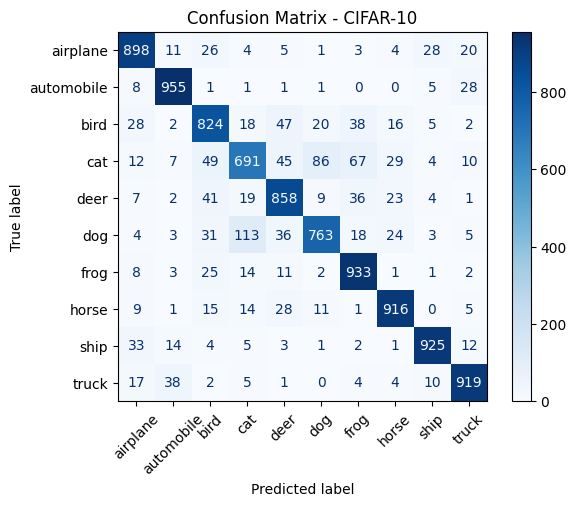

In [ ]:
# Predictions
y_pred_prob = model_architecture6.predict(x_test)  # Απο softmax επιστρεφει ενα διανυσμα πιθανοτητων με 10 στοιχεια πχ : [0.03 0.01 0.02 0.95 .... 0.04] για καθε δειγμα. Το y_pred_prob ειναι πινακας (10.000,10)
y_pred = np.argmax(y_pred_prob, axis=1)  # Επιστρεφει το index του στοιχειου με τη μεγαλυτερη τιμη-πιθανοτητα απο το διανυσμα y_pred_prob και το αναθετει στο y_pred. Ετσι το y_pred ειναι διανυσμα με 10.000 προβλεψεις (0-9)
y_true = y_test     # Η y_true παιρνει τις σωστες ετικετες του testing set, ως αριθμους απο 0-9 γιατι δεν εκανα one-hot. Ειναι ενα διανυσμα 10.000 στοιχειων

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)   # Συγκρινει y_true με y_pred και δινει τον πινακα

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)    # Για ομορφη εμφανιση
plt.figure(figsize=(10,10))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - CIFAR-10")
plt.show()

Καμια σχεση με τους KNN-NCC ετσι; Πολυ μεγαλες τιμες στις διαγωνιους πολυ κοντα στο 1000 που ειναι οι συνολικες εικονες ανα κλαση. Μονο η κατηγορια 'cat' υστερει λιγο σε σχεση με τις αλλες. Πολυ σωστοτερες προβλεψεις, καμια σχεση με τους αλγοριθμους που καναμε στην ενδιαμεση εργασια, οπως και αναμεναμε. Παρατηρουμε οτι μπερδεψε αρκετα τις γατες με σκυλους (102 λαθος προβλεψεις) και τους σκυλους με γατες (101 λαθος προβλεψεις). Αυτο συμβαινει γιατι αυτα τα δυο ζωα μοιαζουν μεταξυ τους,

# **Learning Curves**

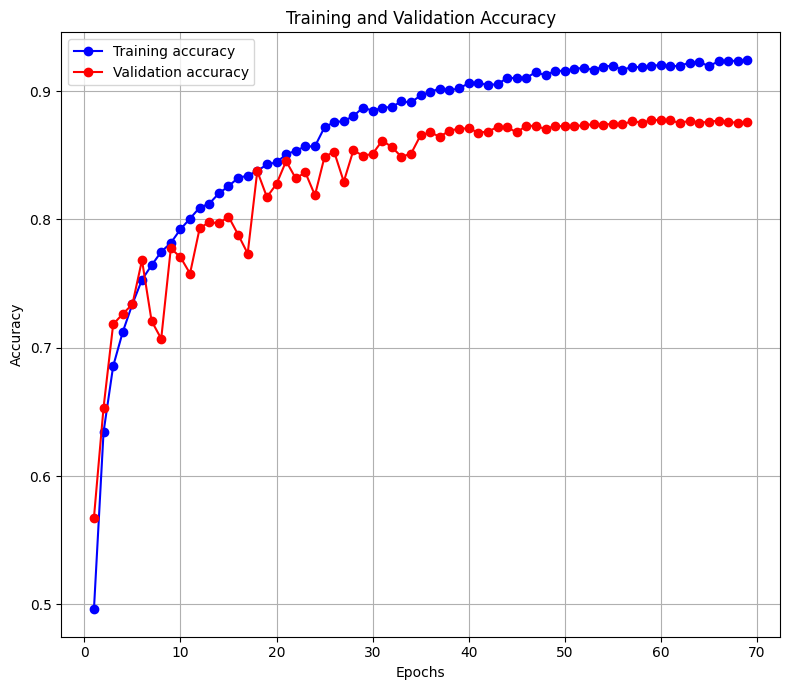

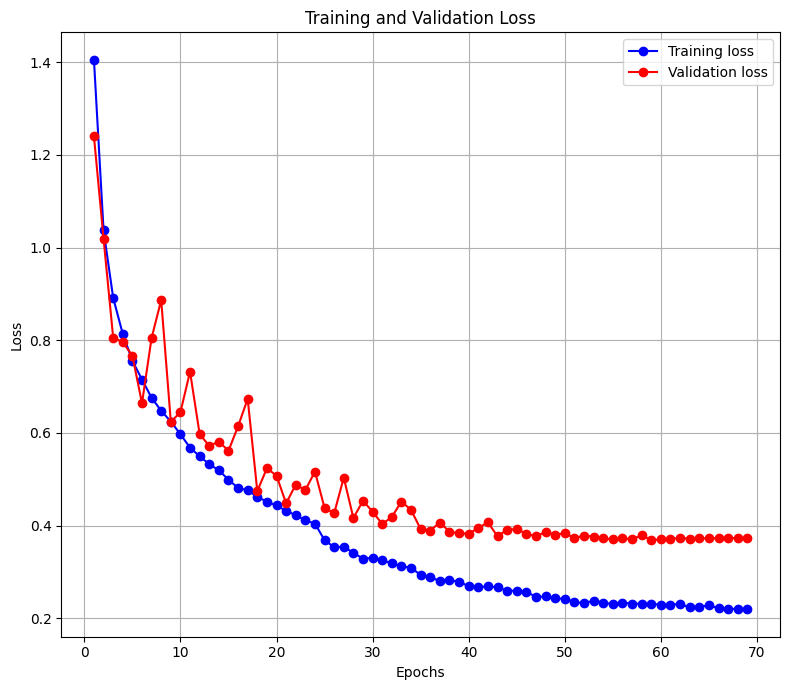

In [ ]:

def plot_learning_curve(history, metric):

    train_values = history.history[metric]
    val_values = history.history['val_' + metric]
    epochs = range(1, len(train_values) + 1)

    plt.figure(figsize=(8,7))
    plt.plot(epochs, train_values, 'bo-', label=f'Training {metric}')
    plt.plot(epochs, val_values, 'ro-', label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curve(model_train6, 'accuracy')
plot_learning_curve(model_train6, 'loss')

# **Testing on personal Images**
Απο ενδιαφερον και μονο, θα τεσταρω το μοντελο μου πανω σε μια δικια μου εικονα γατας. Απλα πρωτα πρεπει να επεξεργαστω την εικονα κατα τα γνωστα: Να την κανω resize σε (32x32) και να κανονικοποιησω τα pixel values της. Ειναι αυτονοητο οτι η εικονα πρεπει να ανηκει σε μια απο τις κατηγοριες εκπαιδευσης.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving input_img.jpg to input_img.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


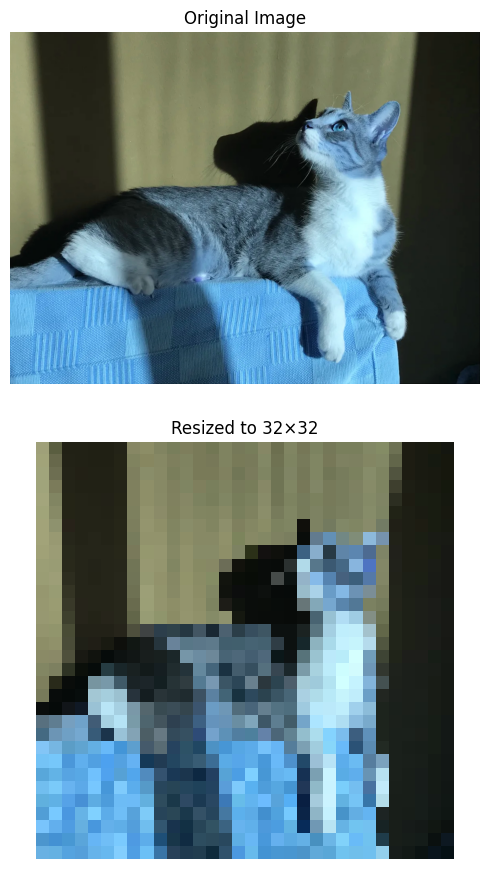

Predicted class index: 3
Predicted class: cat
Probabilities: [[2.6120813e-05 2.4784081e-06 3.8124152e-04 9.8121208e-01 3.4167494e-03
  1.4386685e-02 4.0940137e-04 1.2528464e-04 8.3192809e-08 3.9762908e-05]]


In [ ]:
import cv2

# Load image
img = cv2.imread('input_img.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to CIFAR-10 size
img_resized = cv2.resize(img, (32, 32))

# Normalize
img_norm = img_resized.astype('float32') / 255.0

# Add batch dimension
img_input = np.expand_dims(img_norm, axis=0)  # του δινω διασταση για το batch=1.

# Predict
pred = model_architecture6.predict(img_input)
class_idx = np.argmax(pred)
class_prediction_name = class_names[class_idx]

# VISUALIZE THE IMAGE

# Convert from BGR (OpenCV) to RGB (for correct display)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 9))

# Show original image
plt.subplot(2,1,1)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Original Image")


# Optional: show resized version (32x32 for CIFAR-10)
img_resized = cv2.resize(img_rgb, (32, 32))

plt.subplot(2,1,2)
plt.imshow(img_resized)
plt.axis('off')
plt.title("Resized to 32×32")

plt.tight_layout()
plt.show()

print("Predicted class index:", class_idx)
print("Predicted class:", class_prediction_name)
print("Probabilities:", pred)

Βλεπουμε και τη μεγαλη πιθανοτητα που δινει η softmax στο index 3 του Probabilities διανυσματος προβλεψεων pred.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Airplane.jpg to Airplane.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


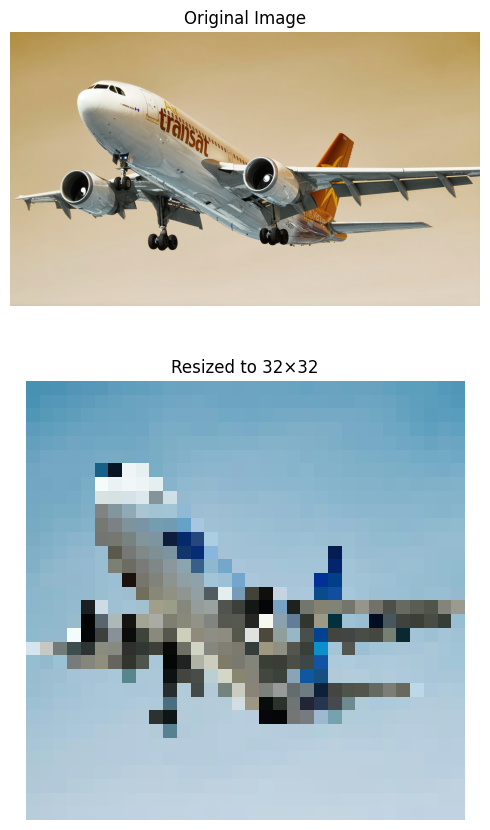

Predicted class index: 0
Predicted class: airplane
Probabilities: [[9.9999797e-01 1.5293007e-07 1.6000140e-06 9.9689927e-09 4.3803286e-10
  1.3251215e-10 1.4600951e-08 4.9879176e-09 1.3807630e-10 2.3646007e-07]]


In [ ]:
import cv2

# Load image
img2 = cv2.imread('Airplane.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Resize to CIFAR-10 size
img2_resized = cv2.resize(img2, (32, 32))

# Normalize
img2_norm = img2_resized.astype('float32') / 255.0

# Add batch dimension
img2_input = np.expand_dims(img2_norm, axis=0)  # του δινω διασταση για το batch=1.

# Predict
pred2 = model_architecture6.predict(img2_input)
class_idx_2 = np.argmax(pred2)
class_prediction_name_2 = class_names[class_idx_2]

# VISUALIZE THE IMAGE

# Convert from BGR (OpenCV) to RGB (for correct display)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 9))

# Show original image
plt.subplot(2,1,1)
plt.imshow(img2_rgb)
plt.axis('off')
plt.title("Original Image")


# Optional: show resized version (32x32 for CIFAR-10)
img_resized = cv2.resize(img2_rgb, (32, 32))

plt.subplot(2,1,2)
plt.imshow(img2_resized)
plt.axis('off')
plt.title("Resized to 32×32")

plt.tight_layout()
plt.show()

print("Predicted class index:", class_idx_2)
print("Predicted class:", class_prediction_name_2)
print("Probabilities:", pred2)

# **ΣΚΕΨΕΙΣ - ΠΑΡΑΤΗΡΗΣΕΙΣ**

**Συνοψη της πορειας που ακολουθησα:**

**Το σκεπτικο μου οπως ειπα στην αρχη, ηταν να βρω την καλυτερη αρχιτεκτονικη πρωτα, και μετα πανω σε αυτη να δοκιμασω ολες τις τεχνικς που συζητησαμε στο μαθημα. Τα πρωτα 7 μοντελα αφορουν την αρχιτεκτονικη, απο τα οποια κρατησα το 6ο. Στο 8ο μοντελο εφαρμοσα Batch Normalization. Στη συνεχεια, στο μοντελο 9 εβαλα momentum στο SGD και ειδα μεγαλη βελτιωση αλλα και μεγαλο overfitting, οποτε αποφασισα να το κοψω με Dropout. Στα μοντελα 10 με 12 εφαρμοσα Dropout/L2 Reg. και κρατησα το 10ο με Dropout μετα το Flatten Layer. Στο 13ο εβαλα Adam. Στα μοντελα 14-17 επαιξα με το learning rate και τελικα κρατησα το μοντελο 14 με lr = 0.0005. Στα μοντελα 18-20 επαιξα με το batch size και τελικα κρατησα το 14 παλι, με batch = 32. Στα 21-23 επαιξα με τις εποχες, και κρατησα το 22 με 50 εποχες. Στο 24 εβαλα Early Stopping. Στα μοντελα 25-28 δοκιμασα διαφορα Data Augmentations και τελικα κρατησα το μοντελο 27. Στο μοντελο 29 προσθεσα Learning Rate Scheduler, το οποιο ηταν και ο τελικο και καλυτερο μοντελο μου. Τελος, το αξιολογησα, και σχεδιασα Confusion Matrix και Learning Curves.**

1. Καποιες φορες, ετρεξα το ιδιο ακριβως μοντελο 2-3 φορες και επαιρνα διαφορετικα αποτελεσματα. Αυτο οφειλεται στην τυχαιοτητα που εμπεριεχεται στο δικτυο. Τα βαρη αρχικοποιουνται τυχαια καθε φορα, τα δειγματα ανακατευονται τυχαια, το data augmentation κανει τυχαιες περιστροφες και flips σε καθε epoch κλπ. Ετσι μπορει σε διαφορετικα run του ιδιου μοντελου να εχεις μια αποκλιση πχ +-1% στα αποτελεσματα. Για παραδειγμα την 1η φορα που ετρεξα το καλυτερο μοντελο μου εδωσε val acc 87.5%, ενω τη 2η και την 3η γυρω στο 86.4%, και validation loss 0.37 στην 1η ενω στις επομενες 0.38, 0.39. Τελικα κρατησα το 5ο run.

2. Ξεχασα τον χρονο εκτελεσης ανα εκπαιδευση που ζητουσατε, και τον εβαλα μονο στο τελευταιο μοντελο και στο evaluation. Ομως ευκολα υπολογιζεται και στα αλλα μοντελα αφου στα logs αναγραφεται ο χρονος ανα epoch, οποτε με μια απλη προσθεση τους βγαινει ο συνολικος χρονος εκπαιδευσης.

3. Πραγματα που θα προσθετα/εκανα διαφορετικα/βελτιωνα στην πορεια που ακολουθησα:


  *  Θα δοκιμζα διαφορετικα dropout rates
  *  Θα δοκιμαζα παραπανω τιμες στο learning rate για να δω ποσο επηρεαζεται ο βελτιστοποιητης. Επισης θα ηθελα να δω καποιες ακραιες τιμες σε "κακους" βελτιστοποιητες οπως το pure SGD για να δω το divergence.
  * Θα δοκιμαζα περισσοτερες τιμες στον L2 reguralizer. Εγω απλα τον συγκρινα με το Dropout.
  * Διαφορες τιμες στο patience του Early Stopping και learning rate scheduler.
  * Ισως να ηταν καλυτερο να βαλω το data augmentation πιο νωρις και να το εβλεπα σαν "αρχιτεκτονικη", και να πειραζα μετα ολες τις υπερπαραμετρους πανω σε αυτη την αρχιτεκτονικη. Βεβαια μετα ολα τα runs θα ηταν ΠΟΛΥ πιο αργα, οποτε θα ηθελε παρα πολυ χρονο.
  * Ισως να εβαζα το Early Stopping στο τελος μετα απο ολα, ωστε να δω που θα φτασει το τελικο μοντελο μου με ολες του τις εποχες, και στο τελος να του εκοβα το overfitting με το Early Stopping. Ωστοσο ετσι θα επετρεπα μεγαλο overfitting σε ολα τα μοντελα μου, το οποιο μου φαινεται που λαθος.
  * Το Batch Normalization φανηκε αναγκαιο για το χτισιμο ενος αξιοπρεπους μοντελου οποτε ισως να ηταν καλυτερο να το θεωρουσα ως αρχιτεκτονικη και να το εβαζα απο την αρχη σε ολα τα μοντελα. Εγω εκρινα τις αρχιτεκτονικες χωρις αυτο υπο συνθηκες underfitting. Προφανως οι ερευνητες σε papers κλπ ξεκινουν με μια πολυ δυνατη αρχιτεκτονικη που περιεχει ολες τις τεχνικες απο την αρχη, αλλα εγω ακολουθησα μια πορεια που ηθελα να δοκιμασω καθε τεχνικη χωριστα για να δω πως συνεισφερει-βελτιωνει το μοντελο.

Ολα αυτα απαιτουν πολλαπλες εκπαιδευσεις και χρονο. Πολυ χρονο. Ηδη εκανα παρα πολλα πιστευω, στα οποια με βοηθησε ΠΑΡΑ πολυ η GPU του Colab. Το τονιζω γιατι μετα απο καποιες ωρες με πετουσε απο τη GPU και δε με αφηνε να τη χρησιμοποιω, και δοκιμασα να εκπαιδευσω με CPU. Εκει που το καθε epoch επαιρνε 20 δευτερολεπτα, με CPU επαιρνε 3 λεπτα. Οποτε μια εκπαιδευση 30 εποχων θα ηθελε μιαμιση ωρα, και δε θα μπορουσα να κανω ουτε τις μισες εκπαιδευσεις που εκανα. Αφου αλλαξα 4 λογαριασμους Google για να μπορεσω να κανω οσα ηθελα με τη GPU.

4. Το test set εμεινε προφανως αθικτο μεχρι το τελος οπου ειχα το καλυτερο μοντελο μου. Μονο τοτε αξιολογησα το μοντελο με το test set. Αν αξιολογουσα καθε μοντελο που εφτιαχνα με το test set, θα ειχα test set leakage, δηλαδη το μοντελο θα εβαζα το μοντελο να μαθει και απο τα test data, οποτε θα χανοταν η αντικειμενικοτητα του.

5. Ως Loss Function χρησιμοποιησα την sparse_categorical_crossentropy, και γι'αυτο το λογο δεν χρειαστηκε να κανω one-hot τα labels (τα κανει αυτη εσωτερικα).

6. Ειχα αρχισει την εργασια με το σκεπτικο να φτιαξω ενα chess engine που να αξιολογει θεσεις. Ωστοσο αφου ολοκληρωσα την ενδιαμεση εργασια και μετα απο συζητηση μας, συνειδητοποιησα τα εμποδια που υπαρχουν σε αυτο το ασυνεχες προβλημα "προβλεψης" (regression) που προσπαθουσα να μετατρεψω σε κατηγοριοποιηση. Οποτε αποφασισα για αρχη να δουλεψω με ενα καλο Dataset σε ενα απλο προβλημα για να δω και να μαθω τις τεχνικες και γενικα τι παιζει, και ισως στο μελλον να το ξαναπροσπαθησω. Θα με ενδιεφερε πολυ, ειδικα αν το δουλευαμε μαζι ισως σε μια διπλωματικη, να φτιαξουμε ενα chess bot ομως, που να προβλεπει οχι μονο ποιος ειναι καλυτερος αλλα και την καλυτερη κινηση σε οποιαδηποτε θεση. Αν θελετε το συζηταμε. Μου λειπουν καποιες προγραμματιστικες ικανοτητες αλλα τιποτα που να μην μαθαινεται, και εφοσον με ενδιαφερει θα μαθω ο,τι χρειαζεται.
